In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
import matplotlib
import scipy.sparse as sparse
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)

Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Figure 3/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
hpoly = sc.read("../data/train_hpoly.h5ad")
hpoly

AnnData object with n_obs × n_vars = 5059 × 7000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts', 'n_genes', 'mt_frac'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_label_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [4]:
salmonella = sc.read("../data/train_salmonella.h5ad")
salmonella

AnnData object with n_obs × n_vars = 4259 × 7000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts', 'n_genes', 'mt_frac'
    var: 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_label_colors', 'condition_colors', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'

In [5]:
hpoly_reconstructed = sc.read("../data/reconstructed/scGen/hpoly.h5ad")
salmonella_reconstructed = sc.read("../data/reconstructed/scGen/salmonella.h5ad")

### Figure 3.a

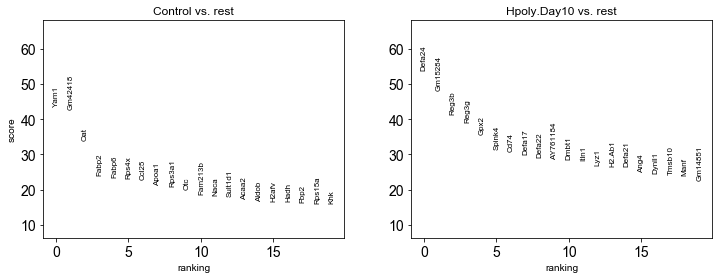

In [6]:
sc.tl.rank_genes_groups(hpoly, groupby="condition", n_genes=100, method="wilcoxon")
sc.pl.rank_genes_groups(hpoly, groupby="condition")
diff_genes = hpoly.uns["rank_genes_groups"]["names"]["Hpoly.Day10"].tolist()[:50] \
           + hpoly.uns["rank_genes_groups"]["names"]["Control"].tolist()[:50]

### Figure 3.a

0.9843550719334775
0.9844520591667748


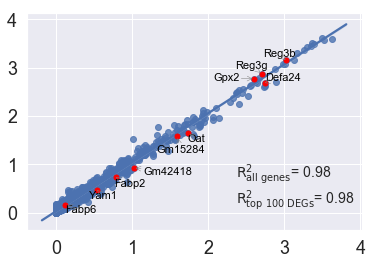

In [9]:
cell_type = "TA.Early"
conditions = {"ctrl": f"{cell_type}_ctrl", "pred_stim": f"{cell_type}_pred_stim", "real_stim": f"{cell_type}_real_stim"}
scgen.plotting.reg_mean_plot(hpoly_reconstructed, 
                             labels={"x": "", "y": ""},
                             condition_key="condition",
                             axis_keys={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                             gene_list=diff_genes[:5] + diff_genes[50:55],
                             top_100_genes=diff_genes,
                             path_to_save=os.path.join(path_to_save, f"Fig3a_hpoly_reg_mean.pdf"),
                             legend=False,
                             fontsize=18,
                             textsize=14,
                             x_coeff=0.35,
                             title="",
                             show=True)

### Figure 3.b

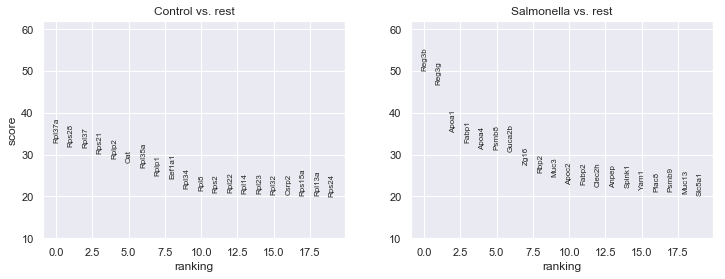

In [10]:
sc.tl.rank_genes_groups(salmonella, groupby="condition", n_genes=100, method="wilcoxon")
sc.pl.rank_genes_groups(salmonella, groupby="condition")
diff_genes = salmonella.uns["rank_genes_groups"]["names"]["Salmonella"].tolist()[:50] \
           + salmonella.uns["rank_genes_groups"]["names"]["Control"].tolist()[:50]

0.9884131383318238
0.9812218771281388


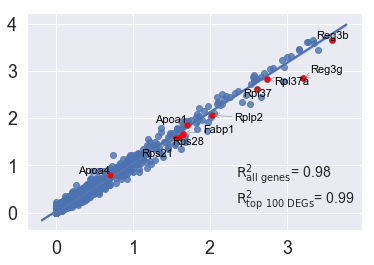

In [13]:
cell_type = "TA.Early"
conditions = {"ctrl": f"{cell_type}_ctrl", "pred_stim": f"{cell_type}_pred_stim", "real_stim": f"{cell_type}_real_stim"}
scgen.plotting.reg_mean_plot(salmonella_reconstructed,
                             labels={"x": "", "y": ""},
                             condition_key="condition",
                             axis_keys={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                             gene_list=diff_genes[:5] + diff_genes[50:55],
                             top_100_genes=diff_genes,
                             path_to_save=os.path.join(path_to_save, f"Fig3b_salmonella_reg_mean.pdf"),
                             fontsize=18, 
                             textsize=14,
                             x_coeff=0.35,
                             legend=False,
                             title="",
                             range=[0, 5, 1],
                             show=True)

### Figure 3.c

In [23]:
def calc_R2(adata, data_name, n_genes=6998, conditions=None):
    if n_genes != adata.shape[1]:
        sc.tl.rank_genes_groups(adata, groupby="condition", n_genes=n_genes, method="wilcoxon")
        if data_name == "hpoly":
            diff_genes = hpoly.uns["rank_genes_groups"]["names"]["Hpoly.Day10"].tolist()[:n_genes//2] \
                       + hpoly.uns["rank_genes_groups"]["names"]["Control"].tolist()[:n_genes//2]
        elif data_name == "salmonella":
            diff_genes = salmonella.uns["rank_genes_groups"]["names"]["Salmonella"].tolist()[:n_genes//2] \
                       + salmonella.uns["rank_genes_groups"]["names"]["Control"].tolist()[:n_genes//2]
        adata = adata[:, diff_genes]
    r_values = np.zeros((1, 100))
    real_stim = adata[adata.obs["condition"] == conditions["real_stim"]]
    pred_stim = adata[adata.obs["condition"] == conditions["pred_stim"]]
    for i in range(100):
        pred_stim_idx = np.random.choice(range(0, pred_stim.shape[0]), int(0.8 * pred_stim.shape[0]))
        real_stim_idx = np.random.choice(range(0, real_stim.shape[0]), int(0.8 * real_stim.shape[0]))
        if sparse.issparse(pred_stim.X):
            pred_stim.X = pred_stim.X.A
            real_stim.X = real_stim.X.A
        x = np.average(pred_stim.X[pred_stim_idx], axis=0)
        y = np.average(real_stim.X[real_stim_idx], axis=0)
        m, b, r_value, p_value, std_err = stats.linregress(x, y)
        r_values[0, i] = r_value ** 2
    return r_values.mean(), r_values.std()

In [24]:
def calc_R2_mean_var(adata, data_name, cell_types, n_genes):
    r2_means, r2_vars = [], []
    for cell_type in cell_types:
        conditions = {"real_stim": cell_type+"_real_stim", "pred_stim": cell_type+"_pred_stim"}
        r2_mean, r2_var = calc_R2(adata, data_name, n_genes=n_genes, conditions=conditions)
        r2_means.append(r2_mean)
        r2_vars.append(r2_var)
    return r2_means, r2_vars

In [25]:
cell_types = hpoly.obs["cell_label"].unique().tolist()

In [26]:
r2_top100_means, r2_top100_vars = calc_R2_mean_var(hpoly_reconstructed, "hpoly", cell_types=cell_types, n_genes=100)
r2_all_means, r2_all_vars = calc_R2_mean_var(hpoly_reconstructed, "hpoly", cell_types=cell_types, n_genes=6998)

In [27]:
all_means = np.concatenate((r2_top100_means, r2_all_means), axis=0)
all_vars = np.concatenate((r2_top100_vars, r2_all_vars), axis=0)
all_types = ["top 100 DEGs"] * len(r2_top100_means) + ["all genes"] * len(r2_top100_means)
cell_types_x = 2 * cell_types
df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Cell Types": cell_types_x})
df

,R^2 Means,R^2 Stddevs,Type,Cell Types
0,0.956714,0.004031,top 100 DEGs,Enterocyte.Progenitor
1,0.952749,0.004279,top 100 DEGs,Stem
2,0.982002,0.002240,top 100 DEGs,TA.Early
3,0.963441,0.007150,top 100 DEGs,TA
4,0.927324,0.015598,top 100 DEGs,Tuft
5,0.883136,0.008741,top 100 DEGs,Enterocyte
6,0.905332,0.012957,top 100 DEGs,Goblet
7,0.882739,0.020263,top 100 DEGs,Endocrine
8,0.959300,0.003468,all genes,Enterocyte.Progenitor
9,0.970593,0.002526,all genes,Stem


In [28]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=14)

In [29]:
def grouped_barplot(df, cat, subcat, val, err, filename, put_label=False, offset=0.375):
    plt.close("all")
    import matplotlib
    matplotlib.rc('ytick', labelsize=20)
    matplotlib.rc('xtick', labelsize=20)
    plt.figure(figsize=(10, 7))
    u = df[cat].unique()
    x_pos = np.arange(0, 2*len(u), 2)
    subx = df[subcat].unique()
#     offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
#     width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        b = plt.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values)
        if put_label:
            autolabel(b)
#         plt.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
#     plt.xlabel(cat)
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=20)
    plt.xticks(x_pos+offset, u, rotation=90)
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_save, filename))
    plt.show()

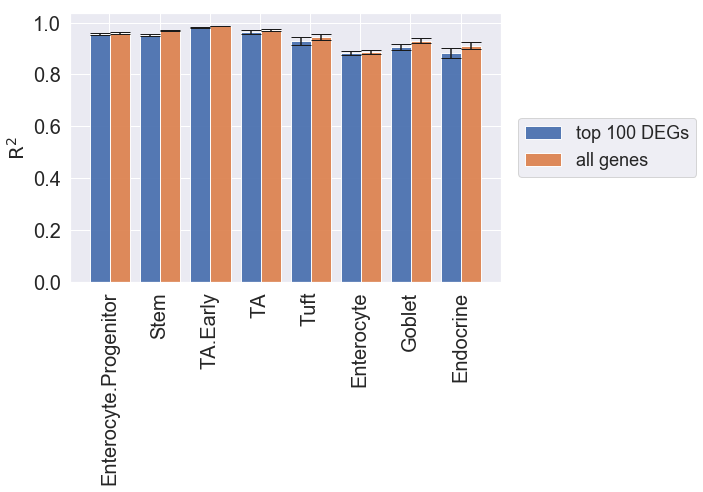

In [30]:
grouped_barplot(df, "Cell Types", "Type", "R^2 Means", "R^2 Stddevs", filename="Fig3c_hpoly_celltypes_barplots.pdf")

### Figure 3.d

In [31]:
r2_top100_means, r2_top100_vars = calc_R2_mean_var(salmonella_reconstructed, "salmonella", cell_types=cell_types, n_genes=100)
r2_all_means, r2_all_vars = calc_R2_mean_var(salmonella_reconstructed, "salmonella", cell_types=cell_types, n_genes=6998)

In [32]:
all_means = np.concatenate((r2_top100_means, r2_all_means), axis=0)
all_vars = np.concatenate((r2_top100_vars, r2_all_vars), axis=0)
all_types = ["top 100 DEGs"] * len(r2_top100_means) + ["all genes"] * len(r2_top100_means)
cell_types_x = 2 * cell_types
df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Cell Types": cell_types_x})
df

,R^2 Means,R^2 Stddevs,Type,Cell Types
0,0.983896,0.002805,top 100 DEGs,Enterocyte.Progenitor
1,0.991394,0.001120,top 100 DEGs,Stem
2,0.987306,0.002031,top 100 DEGs,TA.Early
3,0.989919,0.001897,top 100 DEGs,TA
4,0.826958,0.056733,top 100 DEGs,Tuft
5,0.933460,0.004850,top 100 DEGs,Enterocyte
6,0.899985,0.022720,top 100 DEGs,Goblet
7,0.863084,0.028010,top 100 DEGs,Endocrine
8,0.983613,0.002814,all genes,Enterocyte.Progenitor
9,0.984745,0.001765,all genes,Stem


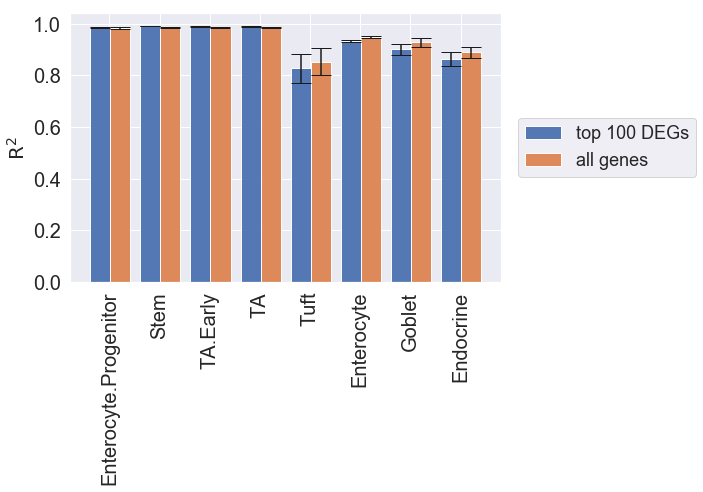

In [33]:
grouped_barplot(df, "Cell Types", "Type", "R^2 Means", "R^2 Stddevs", filename="Fig3d_salmonella_celltypes_barplots.pdf")